In [1]:
# import zipfile

# # Open the zip file
# with zipfile.ZipFile('mit-bih-arrhythmia-database-1.0.0.zip', 'r') as zip_ref:
#     # Extract all the contents of the zip file in current directory
#     zip_ref.extractall()
import wfdb
import csv
import glob
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz, hilbert
import peakutils
import matplotlib.pyplot as plt
from scipy import interpolate
import argparse
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

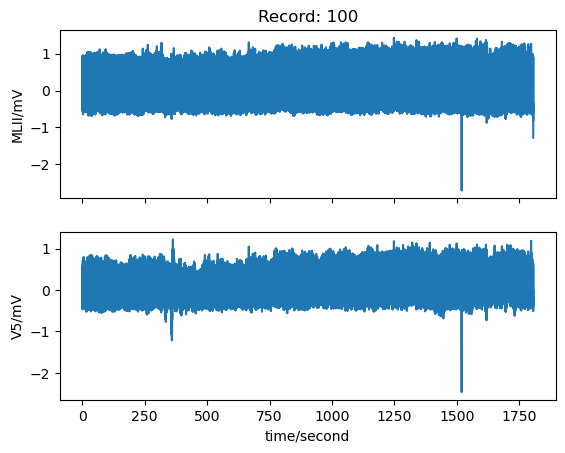

In [2]:
path = 'mit-bih-arrhythmia-database-1.0.0/'
patient_record = wfdb.rdrecord("100")
wfdb.plot_wfdb(patient_record)

In [3]:
# collect the file names
path = 'mit-bih-arrhythmia-database-1.0.0/'
path = ''
dat_files = glob.glob('*.*')
file_names = []
for i in range(len(dat_files)):
    file_name = dat_files[i][len(path):-4]
    if len(file_name) <4:
        file_names.append(dat_files[i][len(path):-4])
file_names = list(set(file_names))

In [4]:
# Open ECG file
def read_ecg_of_a_patient(patient_number):
    patient_record = wfdb.rdrecord(patient_number) # PUT PATIENT NUMBER HERE

    # Extract patient info, lead names, and ECG data
#     patient_number = patient_record.record_name
    leads = patient_record.sig_name
    ecg_data = patient_record.p_signal

    # Create DataFrame
    df = pd.DataFrame(ecg_data, columns=leads)
    return(df)

def read_ecg_of_all_patients(file_names =file_names):
    
    patient_dict = {}
    for patient_number in file_names:
        patient_dict[patient_number] = read_ecg_of_a_patient(patient_number)
        
    return(patient_dict)
patient_dict = read_ecg_of_all_patients()

## Read 1 File and Display

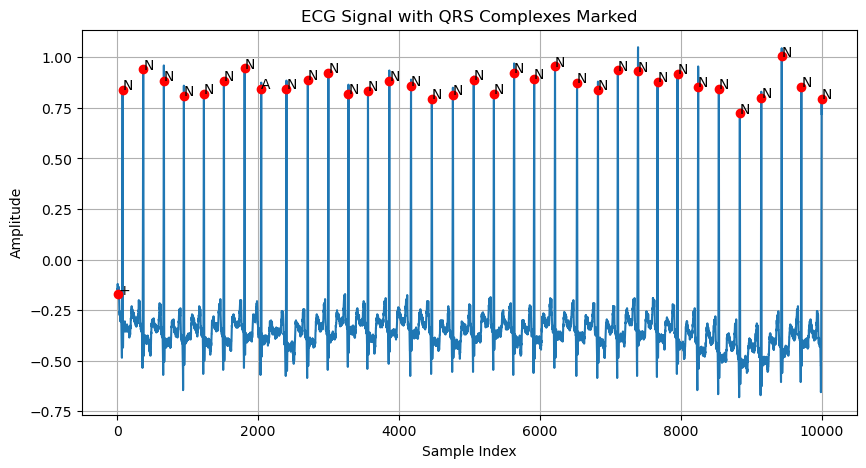

In [5]:
# Read the .dat file
signals, fields = wfdb.rdsamp('100')

# Read the annotation file
annotation = wfdb.rdann('100', 'atr')

# Get the indices of the QRS complexes
qrs_indices = annotation.sample

# Get the symbols of the annotations
symbols = annotation.symbol

# Plot the first 1000 samples of the first signal in the record
length = 10000
plt.figure(figsize=(10, 5))
plt.plot(signals[:length, 0])

# Add markers for the QRS complexes
plt.plot(qrs_indices[qrs_indices < length], signals[qrs_indices[qrs_indices < length], 0], 'ro')

# Add annotation symbols to the plot
for i in range(len(qrs_indices)):
    if qrs_indices[i] < length:
        plt.text(qrs_indices[i], signals[qrs_indices[i], 0], symbols[i])

plt.title('ECG Signal with QRS Complexes Marked')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


## Convert Recorded File to a Data Frame and Get Target Value

In [6]:
# Read the .dat file
signals, fields = wfdb.rdsamp('100')

# Read the annotation file
annotation = wfdb.rdann('100', 'atr')

# Get the indices of the QRS complexes
qrs_indices = annotation.sample

# Get the symbols of the annotations
symbols = annotation.symbol

# Create a DataFrame for the signals
signals_df = pd.DataFrame(signals, columns=fields['sig_name'])

# Create a list to store the data for each beat
data = []

# Loop through the QRS indices
for i in range(len(qrs_indices) - 1):
    # Get the data for one beat from the first channel
    beat_data = signals_df.iloc[qrs_indices[i]:qrs_indices[i+1], 0].values.tolist()
    
    # Add the beat data and the corresponding annotation to the list
    data.append([beat_data, symbols[i]])

# Create a DataFrame with the beat data
df = pd.DataFrame(data, columns=['Signal', 'Annotation'])

df.head()


,Signal,Annotation
0,"[-0.17, -0.155, -0.175, -0.18, -0.19, -0.18, -...",+
1,"[0.84, 0.765, 0.52, 0.17, -0.165, -0.365, -0.4...",N
2,"[0.94, 0.905, 0.755, 0.49, 0.165, -0.11, -0.27...",N
3,"[0.885, 0.96, 0.85, 0.52, 0.05, -0.32, -0.5, -...",N
4,"[0.81, 0.86, 0.77, 0.475, 0.065, -0.305, -0.5,...",N


### How 1 signal looks like?

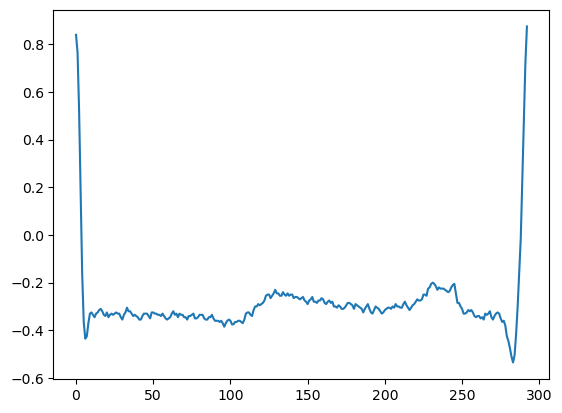

In [7]:
plt.plot(df.iloc[1,0])

## Select Some Annotations to Classify
    # N, f, V, A, F
    Only Selected N & V to make it a binary classification

In [8]:


def process_file(filename):
    # Read the .dat file
    signals, fields = wfdb.rdsamp(filename)

    # Read the annotation file
    annotation = wfdb.rdann(filename, 'atr')

    # Get the indices of the QRS complexes
    qrs_indices = annotation.sample

    # Get the symbols of the annotations
    symbols = annotation.symbol

    # Create a DataFrame for the signals
    signals_df = pd.DataFrame(signals, columns=fields['sig_name'])

    # Create a list to store the data for each beat
    data = []

    # Loop through the QRS indices
    for i in range(len(qrs_indices) - 1):
        # Get the data for one beat from the first channel
        beat_data = signals_df.iloc[qrs_indices[i]:qrs_indices[i+1], 0].values.tolist()
        
        # Add the beat data and the corresponding annotation to the list
        data.append([beat_data, symbols[i]])

    # Create a DataFrame with the beat data
    df = pd.DataFrame(data, columns=['Signal', 'Annotation'])

    # Define the annotations to keep
    # N, f, V, A, F
    annotations_to_keep = ["N", "V"] #"f", "V", "A"] #, "F"]
    

    # Filter the DataFrame
    df_filtered = df[df['Annotation'].isin(annotations_to_keep)]
    
    return df_filtered
    return df

# List of files to process
recnums = ['100', '101', '102', '103', '104', '105', '106', '107', '108',
           '109','111', '112', '113', '114', '115', '116', '117', '118',
           '119','121', '122', '123', '124']

# Process each file
dfs = [process_file(recnum) for recnum in recnums]

# convert them to dataframe
df_concatenated = pd.concat(dfs, ignore_index=True)
df_concatenated.head()

,Signal,Annotation
0,"[0.84, 0.765, 0.52, 0.17, -0.165, -0.365, -0.4...",N
1,"[0.94, 0.905, 0.755, 0.49, 0.165, -0.11, -0.27...",N
2,"[0.885, 0.96, 0.85, 0.52, 0.05, -0.32, -0.5, -...",N
3,"[0.81, 0.86, 0.77, 0.475, 0.065, -0.305, -0.5,...",N
4,"[0.82, 0.78, 0.535, 0.145, -0.2, -0.42, -0.5, ...",N


In [9]:
counts = df_concatenated['Annotation'].value_counts()
counts

N    31529
V     1346
Name: Annotation, dtype: int64

In [10]:
# from sklearn.utils import resample

# # Separate majority and minority classes
# df_majority = df_concatenated[df_concatenated.Annotation=='N']
# df_minority = df_concatenated[df_concatenated.Annotation=='V']

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=31529,  # to match majority class
#                                  random_state=123) # reproducible results

# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# # Display new class counts
# df_upsampled.Annotation.value_counts()
# df_concatenated = df_upsampled
# df_concatenated.index = list(range(df_concatenated.shape[0]))
# df_concatenated

# Training Data
    N and V counts are matched on the smaller count V

In [11]:
# Group by 'Annotation' and sample 155 from each
df_concatenated = df_concatenated.groupby('Annotation').apply(lambda x: x.sample(n=1346))

# Reset the index
df_concatenated.reset_index(drop=True, inplace=True)
counts = df_concatenated['Annotation'].value_counts()
counts

N    1346
V    1346
Name: Annotation, dtype: int64

## Apply Interpolation 

### Training Data

In [12]:
# Get the signal data for the first row
signal_data = df_concatenated.iloc[0, 0]

# Create an interpolation function
f = interpolate.interp1d(np.linspace(0, 1, len(signal_data)), signal_data, kind='linear')

# Use the interpolation function to get 128 data points
interpolated_data = f(np.linspace(0, 1, 128))
interpolated_data

array([ 1.        ,  0.87409449,  0.02826772, -1.08488189, -1.12897638,
       -0.8803937 , -0.96295276, -1.06889764, -1.09437008, -1.10547244,
       -1.12692913, -1.12862205, -1.12      , -1.13598425, -1.14629921,
       -1.1657874 , -1.11334646, -1.11877953, -1.13905512, -1.155     ,
       -1.13271654, -1.09220472, -1.12826772, -1.135     , -1.11251969,
       -1.0919685 , -1.05598425, -1.07787402, -1.06019685, -1.04547244,
       -1.0115748 , -0.99992126, -0.96917323, -0.93846457, -0.88523622,
       -0.84625984, -0.80594488, -0.75582677, -0.70464567, -0.61511811,
       -0.59043307, -0.57704724, -0.52440945, -0.49338583, -0.48948819,
       -0.50791339, -0.59350394, -0.63543307, -0.68870079, -0.78433071,
       -0.87318898, -0.94133858, -0.9619685 , -1.00110236, -1.04149606,
       -1.07377953, -1.0746063 , -1.06149606, -1.07862205, -1.09      ,
       -1.085     , -1.06692913, -1.06496063, -1.07169291, -1.085     ,
       -1.06      , -1.04192913, -1.03629921, -1.055     , -1.05

#### Convert all of them to a Dataframe

In [13]:
# Function to interpolate a signal to 128 data points
def interpolate_signal(signal):
    f = interpolate.interp1d(np.linspace(0, 1, len(signal)), signal, kind='linear')
    return f(np.linspace(0, 1, 128))

# Apply the function to the 'Signal' column
df_concatenated['Interpolated_Signal'] = df_concatenated['Signal'].apply(interpolate_signal)

# Split the interpolated signals into separate columns
interpolated_df = pd.DataFrame(df_concatenated['Interpolated_Signal'].to_list(), columns=[f'Signal_{i}' for i in range(128)])

# Add the 'Annotation' column
interpolated_df['Annotation'] = df_concatenated['Annotation']

interpolated_df


,Signal_0,Signal_1,Signal_2,Signal_3,Signal_4,Signal_5,Signal_6,Signal_7,Signal_8,Signal_9,...,Signal_119,Signal_120,Signal_121,Signal_122,Signal_123,Signal_124,Signal_125,Signal_126,Signal_127,Annotation
0,1.000,0.874094,0.028268,-1.084882,-1.128976,-0.880394,-0.962953,-1.068898,-1.094370,-1.105472,...,-1.104370,-1.100000,-1.094843,-1.111929,-1.161772,-1.103189,-0.711339,0.070197,0.895,N
1,1.170,0.984567,0.090748,-0.460945,-0.439882,-0.346890,-0.358268,-0.359291,-0.363071,-0.375197,...,-0.318976,-0.325354,-0.338661,-0.431102,-0.482953,-0.534606,-0.249213,0.199370,0.830,N
2,-1.665,-1.294803,-1.087756,-0.873031,-0.786299,-0.809252,-0.815551,-0.781929,-0.750000,-0.774173,...,-0.940000,-0.897047,-0.892205,-0.884370,-0.620079,-0.154488,-0.130512,-0.911811,-1.605,N
3,1.700,1.559370,0.288268,-0.524094,-0.491181,-0.270354,-0.249961,-0.268071,-0.273307,-0.291220,...,-0.292795,-0.300000,-0.294173,-0.348543,-0.425551,-0.309961,0.008701,0.846457,1.525,N
4,0.410,0.310945,0.088268,-0.192598,-0.448976,-0.593110,-0.622756,-0.579882,-0.574488,-0.594567,...,-0.694488,-0.682677,-0.695000,-0.680000,-0.583228,-0.344843,-0.085984,0.049252,0.160,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,1.305,1.042205,-0.107126,-0.617402,-0.878228,-1.022402,-0.915157,-0.826457,-0.728386,-0.645118,...,-0.130079,-0.173819,-0.209961,-0.231299,-0.198307,-0.192480,-0.094961,0.369331,1.085,V
2688,-0.730,-0.942323,-1.613937,-2.162323,-1.955472,-2.019055,-2.403937,-2.542165,-2.404134,-2.280945,...,-1.019094,-1.043583,-0.976220,-0.714291,-0.680709,-0.819291,-0.087913,0.778031,1.345,V
2689,1.875,1.630906,1.097559,0.252598,-0.365197,-0.597520,-0.686063,-0.667520,-0.557441,-0.463937,...,-0.270000,-0.269567,-0.231063,-0.188976,-0.174528,-0.376260,0.008268,1.045748,1.680,V
2690,-0.610,-0.772520,-1.604213,-1.489685,-1.777992,-2.107008,-2.203110,-2.100000,-1.980709,-1.557441,...,-0.822520,-0.800000,-0.846850,-0.716024,-0.364173,-0.736811,-0.290512,0.957874,1.680,V


#### Statistics of the Lengths DataFrame

In [14]:
lengths = df_concatenated['Signal'].apply(len)
lengths.describe()

count    2692.000000
mean      351.313522
std        93.632232
min        64.000000
25%       276.000000
50%       349.000000
75%       433.000000
max       603.000000
Name: Signal, dtype: float64

In [15]:

# Define the annotations to select
annotations_to_select = ["N", "V"] #["N", "f", "V", "A"] #, "F"]


# Create an empty DataFrame to store the selected rows
df_selected = pd.DataFrame()

# Loop through the annotations
for annotation in annotations_to_select:
    n = counts[annotation]
    # Get the rows for the current annotation
    df_annotation = df_concatenated[df_concatenated['Annotation'] == annotation]
    
    # Randomly select 'n' rows
    df_sample = df_annotation.sample(n)
    
    # Add the selected rows to df_selected
    df_selected = pd.concat([df_selected, df_sample])

df_selected = df_selected.reset_index(drop=True)
df_selected.head()


,Signal,Annotation,Interpolated_Signal
0,"[0.98, 1.26, 1.325, 1.09, 0.55, -0.09, -0.73, ...",N,"[0.98, 1.2602362204724409, 0.19724409448818925..."
1,"[1.04, 1.13, 1.065, 0.8, 0.39, -0.12, -0.67, -...",N,"[1.04, 0.6708661417322835, -0.9692125984251968..."
2,"[1.475, 1.49, 1.37, 1.015, 0.46, -0.105, -0.54...",N,"[1.475, 1.1799212598425197, -0.135826771653543..."
3,"[1.585, 1.66, 1.495, 1.06, 0.42, -0.22, -0.86,...",N,"[1.585, 1.2620866141732283, -0.265354330708661..."
4,"[0.945, 0.94, 0.905, 0.835, 0.745, 0.63, 0.465...",N,"[0.945, 0.9016929133858268, 0.7341338582677166..."


### Test Data

In [16]:
# List of files to process
testnums = ['200', '201', '202', '203', '205', '207', '208', '209', 
            '210', '212', '213', '214', '215', '217', '219', '220', 
            '221', '222', '223', '228', '230', '231', '232', '233', 
            '234']


# Process each file
dfs_test = [process_file(testnum) for testnum in testnums]

# convert them to dataframe
df_concatenated_test = pd.concat(dfs_test, ignore_index=True)
df_concatenated_test.head()

,Signal,Annotation
0,"[-1.49, -1.45, -1.39, -1.34, -1.27, -1.155, -1...",V
1,"[1.06, 1.11, 1.1, 1.005, 0.86, 0.615, 0.24, -0...",N
2,"[-2.01, -2.0, -1.965, -1.905, -1.845, -1.75, -...",V
3,"[0.995, 1.025, 1.005, 0.92, 0.79, 0.57, 0.225,...",N
4,"[-2.08, -2.055, -1.995, -1.9, -1.805, -1.705, ...",V


In [17]:
# Function to interpolate a signal to 128 data points
def interpolate_signal(signal):
    f = interpolate.interp1d(np.linspace(0, 1, len(signal)), signal, kind='linear')
    return f(np.linspace(0, 1, 128))

# Apply the function to the 'Signal' column
df_concatenated_test['Interpolated_Signal'] = df_concatenated_test['Signal'].apply(interpolate_signal)

# Split the interpolated signals into separate columns
interpolated_df_test = pd.DataFrame(df_concatenated_test['Interpolated_Signal'].to_list(), columns=[f'Signal_{i}' for i in range(128)])

# Add the 'Annotation' column
interpolated_df_test['Annotation'] = df_concatenated_test['Annotation']

interpolated_df_test.head()


,Signal_0,Signal_1,Signal_2,Signal_3,Signal_4,Signal_5,Signal_6,Signal_7,Signal_8,Signal_9,...,Signal_119,Signal_120,Signal_121,Signal_122,Signal_123,Signal_124,Signal_125,Signal_126,Signal_127,Annotation
0,-1.490,-1.387244,-1.257323,-1.012598,-0.930000,-0.903110,-0.856732,-0.782638,-0.690748,-0.605197,...,-0.170000,-0.203425,-0.201575,-0.063425,0.108465,0.302638,0.490630,0.718386,0.940,V
1,1.060,1.104173,0.981024,0.676732,0.124252,-0.315512,-0.487283,-0.537638,-0.463701,-0.378898,...,0.249764,0.201575,0.169843,0.012480,-0.492717,-1.187008,-1.700354,-1.920039,-1.995,N
2,-2.010,-1.955551,-1.815079,-1.543583,-1.302756,-1.191693,-1.038858,-0.823858,-0.702008,-0.569528,...,-0.188701,-0.209488,-0.213071,-0.114370,0.031457,0.242756,0.414803,0.657165,0.905,V
3,0.995,1.016339,0.931378,0.724173,0.317362,-0.155551,-0.391850,-0.505472,-0.508386,-0.445630,...,-0.066417,-0.157638,-0.328268,-0.647008,-1.157717,-1.638740,-1.944055,-2.052008,-2.060,N
4,-2.080,-1.971811,-1.756181,-1.565433,-1.327717,-1.127362,-0.969449,-0.883110,-0.763307,-0.649094,...,-0.209764,-0.196457,-0.225709,-0.227205,-0.082638,0.139094,0.351299,0.648386,0.950,V


In [18]:

# Create an empty DataFrame to store the selected rows
df_selected_test = pd.DataFrame()

counts = df_concatenated_test['Annotation'].value_counts()

# Loop through the annotations
for annotation in annotations_to_select:
    n = counts[annotation]
    print("annotation: ", annotation, "n: ", n)
    # Get the rows for the current annotation
    df_annotation_test = df_concatenated_test[df_concatenated_test['Annotation'] == annotation]
    
    # Randomly select 'n' rows
    df_sample_test = df_annotation_test.sample(n)
    
    # Add the selected rows to df_selected
    df_selected_test = pd.concat([df_selected_test, df_sample_test])


df_selected_test


annotation:  N n:  43487
annotation:  V n:  5784


,Signal,Annotation,Interpolated_Signal
13851,"[1.2, 1.04, 0.755, 0.445, 0.155, -0.07, -0.175...",N,"[1.2, 0.9704330708661417, 0.6036614173228346, ..."
28491,"[1.315, 1.29, 1.22, 1.1, 0.9, 0.575, 0.165, -0...",N,"[1.315, 1.2398425196850393, 1.0133858267716536..."
14069,"[1.54, 1.665, 1.635, 1.375, 0.95, 0.475, 0.055...",N,"[1.54, 1.6503543307086614, 1.3811417322834645,..."
45844,"[1.7, 1.67, 1.595, 1.465, 1.305, 1.08, 0.835, ...",N,"[1.7, 1.622755905511811, 1.4234251968503937, 1..."
39179,"[0.3, 0.27, 0.235, 0.19, 0.13, 0.095, 0.035, -...",N,"[0.3, 0.20381889763779526, 0.07185039370078738..."
...,...,...,...
46459,"[-1.74, -1.725, -1.705, -1.665, -1.61, -1.53, ...",V,"[-1.74, -1.6961811023622049, -1.57472440944881..."
38395,"[0.28, 0.175, 0.045, -0.105, -0.26, -0.375, -0...",V,"[0.28, -0.03177165354330708, -0.37712598425196..."
23845,"[1.655, 1.69, 1.605, 1.395, 1.05, 0.675, 0.325...",V,"[1.655, 1.3216535433070866, 0.1783070866141733..."
2041,"[1.795, 1.765, 1.61, 1.335, 1.045, 0.82, 0.64,...",V,"[1.795, 1.393464566929134, 0.7165354330708662,..."


# Apply Classifier to Raw Data

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     43487
           1       0.37      0.88      0.52      5784

    accuracy                           0.81     49271
   macro avg       0.67      0.84      0.70     49271
weighted avg       0.91      0.81      0.84     49271



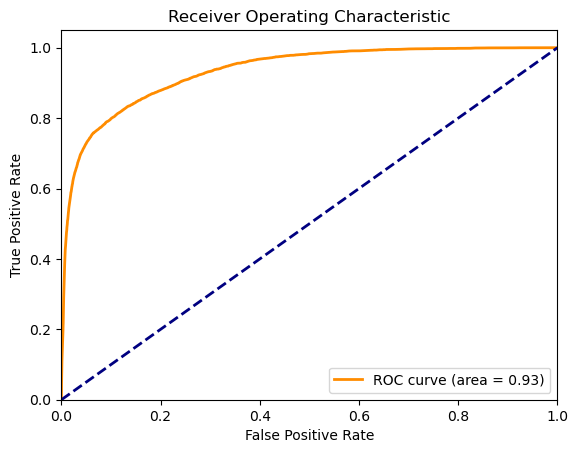

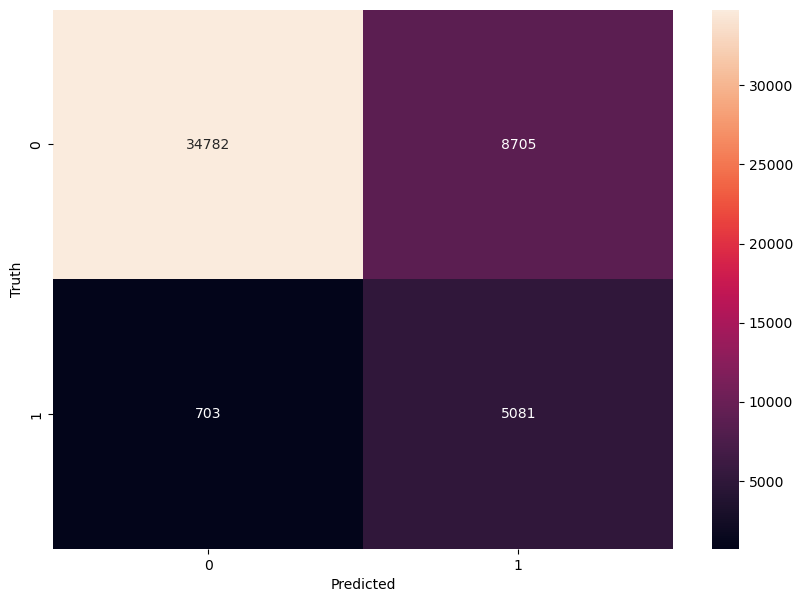

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Prepare the features and target variable
X_train = np.stack(df_selected['Interpolated_Signal'].values)
y_train = df_selected['Annotation'].values
X_test = np.stack(df_selected_test['Interpolated_Signal'].values)
y_test = df_selected_test['Annotation'].values

# Define a mapping dictionary
mapping = {'N': 0, 'V': 1}

# Apply the mapping to y_train and y_test
y_train = np.array([mapping[i] for i in y_train])
y_test = np.array([mapping[i] for i in y_test])


# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# PCA + ICA

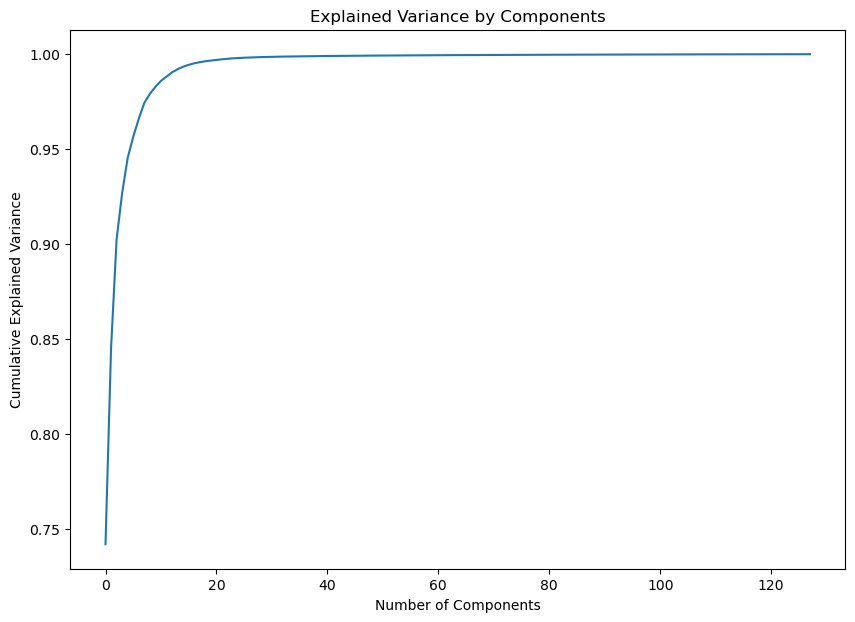

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10,7))
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()


In [21]:
cumulative_explained_variance[:20]

array([0.74207469, 0.84519488, 0.90257993, 0.92696952, 0.94542347,
       0.95658142, 0.9660499 , 0.97439819, 0.97913781, 0.98284602,
       0.98597264, 0.98825135, 0.99046183, 0.9921203 , 0.99344552,
       0.9944302 , 0.99522355, 0.99579901, 0.99631218, 0.99667003])

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=6)  # 0.95 means it will return the number of components that explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components: {pca.n_components_}")


Number of PCA components: 6


In [23]:
from sklearn.decomposition import FastICA

# Apply ICA
ica = FastICA(n_components=6, whiten='unit-variance')
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)


C:\Users\adoga\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.77      0.86     43487
           1       0.34      0.89      0.49      5784

    accuracy                           0.78     49271
   macro avg       0.66      0.83      0.68     49271
weighted avg       0.91      0.78      0.82     49271



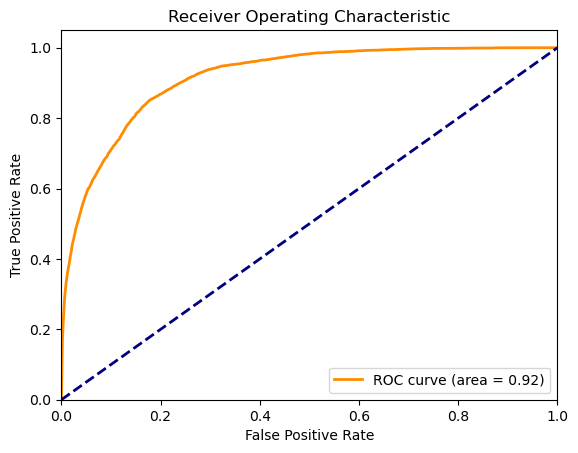

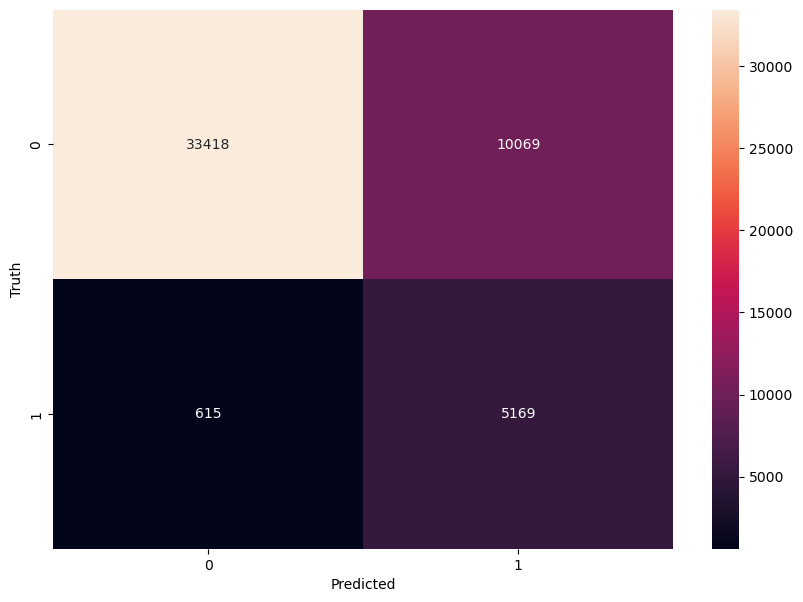

In [24]:
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(X_train_ica, y_train)

# Predict the classes of the test set
y_pred = clf.predict(X_test_ica)

# Print the classification report
print(classification_report(y_test, y_pred))


# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(X_test_ica)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# IB as without DL 

In [25]:

import numpy as np
from scipy.stats import entropy

def information_bottleneck(p_x_y, num_clusters):
    # Initialize
    p_y_given_t = np.random.dirichlet([1]*p_x_y.shape[0], num_clusters).T
    p_y_given_t /= p_y_given_t.sum(axis=0)

    while True:
        # E-step
        p_t_given_y = p_y_given_t / p_y_given_t.sum(axis=1, keepdims=True)
        p_t = p_t_given_y.sum(axis=0)
        p_t_given_y = p_t_given_y * p_t
        p_t_given_y /= p_t_given_y.sum(axis=1, keepdims=True)

        # M-step
#         p_y_given_t_new = p_x_y @ p_t_given_y
        p_x_y_mean = np.mean(p_x_y, axis=1, keepdims=True)
        p_y_given_t_new = p_x_y_mean * p_t_given_y
        p_y_given_t_new /= p_y_given_t_new.sum(axis=0)

        # Check for convergence
        if np.allclose(p_y_given_t, p_y_given_t_new):
            break

        p_y_given_t = p_y_given_t_new

    return p_y_given_t, p_t_given_y

# Test the function
ecg_data = X_train

# Normalize the data
ecg_data = ecg_data / np.sum(ecg_data)

# Define the number of clusters
num_clusters = 6
p_y_given_t_train, p_t_given_y = information_bottleneck(X_train, num_clusters)
p_y_given_t_test, p_t_given_y = information_bottleneck(X_test, num_clusters)

# print("p(y|t):", p_y_given_t_train)
# print("p(t|y):", p_y_given_t_test)

              precision    recall  f1-score   support

           0       0.88      0.18      0.29     43487
           1       0.12      0.82      0.20      5784

    accuracy                           0.25     49271
   macro avg       0.50      0.50      0.25     49271
weighted avg       0.79      0.25      0.28     49271



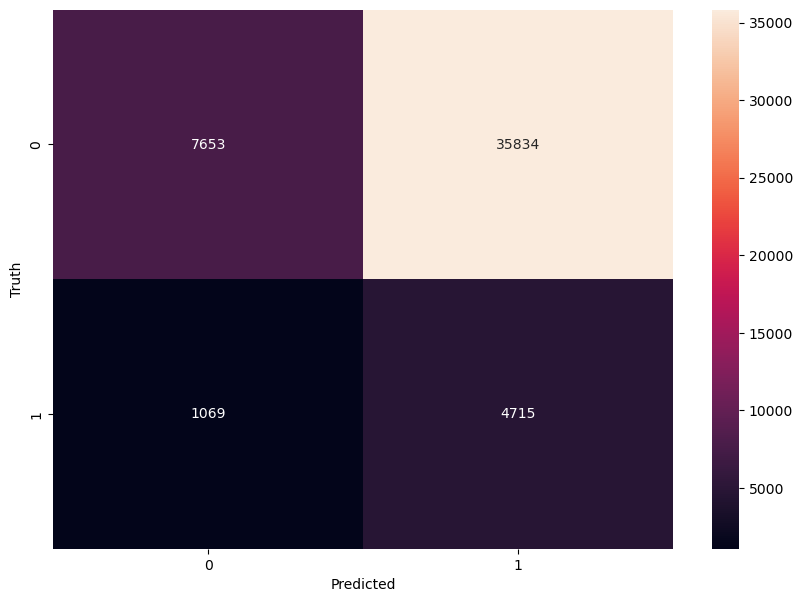

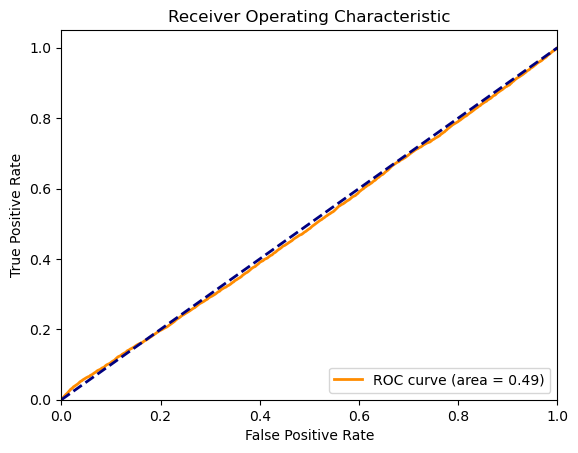

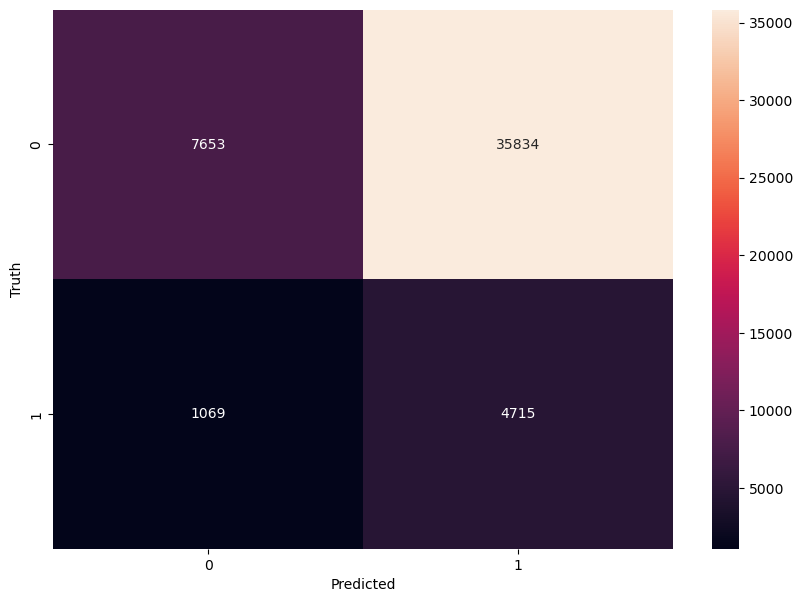

In [26]:
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(p_y_given_t_train, y_train)

# Predict the classes of the test set
y_pred = clf.predict(p_y_given_t_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(p_y_given_t_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# DL IB Model (3 Loss)
(Loss Function from https://github.com/YangLing0818/GraphOOD/blob/main/model/gnn.py#L124 )

In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

Epoch [0/200], Loss: 16037.6426
Epoch [20/200], Loss: 6599.2568
Epoch [40/200], Loss: 4115.6274
Epoch [60/200], Loss: 3012.2710
Epoch [80/200], Loss: 2423.3633
Epoch [100/200], Loss: 2121.0186
Epoch [120/200], Loss: 1861.0702
Epoch [140/200], Loss: 1638.8735
Epoch [160/200], Loss: 1520.8490
Epoch [180/200], Loss: 1409.0107


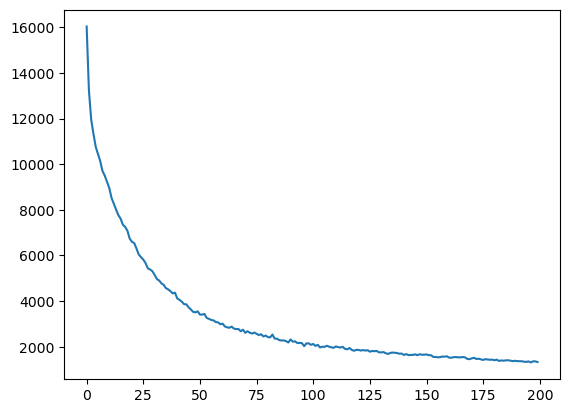

In [29]:
class SimpleModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(SimpleModel, self).__init__()
        self.norm = nn.BatchNorm1d(in_channels)
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.bns = torch.nn.BatchNorm1d(hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        self.feature_IB_fc = nn.Linear(in_features=in_channels, out_features=hidden_channels, bias=False)

    def forward(self, x):
        x = self.norm(x)
        first_l_x = x
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        feat = x
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1), first_l_x, feat

    # compute relational ground truth for S-GIB
    def compute_label_rel_IB_loss(self, nodes_feature, labels):
        select_node_batch = torch.cat(nodes_feature, dim=0)
        select_label_batch = torch.cat(labels, dim=0)
        label_same = select_label_batch.unsqueeze(dim=1) == select_label_batch.unsqueeze(dim=0)
        label_diff = select_label_batch.unsqueeze(dim=1) != select_label_batch.unsqueeze(dim=0)
        x_after = select_node_batch
        x_rel = torch.mm(x_after, select_node_batch.T)
        sig_x_rel = torch.sigmoid(x_rel)

        same_label_eles = torch.log(sig_x_rel)[label_same]
        diff_label_eles = torch.log(1 - sig_x_rel + 1e-20)[label_diff]
        same_label_pairs = -torch.sum(same_label_eles)
        diff_label_pairs = -torch.sum(diff_label_eles)
        return same_label_pairs, diff_label_pairs

    # compute I-GIB loss
    def compute_first_last_feature_IB_loss(self, first_layer_feature, last_layer_feature):
        first_features = first_layer_feature
        last_features = last_layer_feature
        first_features_after = self.feature_IB_fc(first_features)
        sig_features_rel = torch.sigmoid(torch.sum(torch.mul(first_features_after, last_features), dim=-1))
        return -torch.sum(torch.log(1 - sig_features_rel + 1e-20))

    # compute S-GIB loss
    def compute_first_last_feature_IB_loss_2nd_order(self, first_layer_feature, last_layer_feature):
        first_features = first_layer_feature
        last_features = last_layer_feature
        first_features_rel = torch.mm(first_features, first_features.T)
        last_feature_rel = torch.mm(last_features, last_features.T)
        f_l_rel = first_features_rel - last_feature_rel
        return torch.norm(f_l_rel, p='fro')

# Create the model
model = SimpleModel(
    in_channels=X_train.shape[1],  # Input feature dimension
    hidden_channels=48,  # Dimension of hidden layers
    out_channels=10, #num_classes['your_dataset'],  # Output dimension
    dropout=0.5  # Dropout rate
)

class Args:
    first_last_layer_IB_loss = True
    first_last_layer_2nd_IB_loss = True
    cross_graph_label_rel_IB_loss = True
    label_rel_IB_loss_weight_1 = 1e-2
    label_rel_IB_loss_weight_2 = 1e-5
    in_out_feature_rel_loss_weight = 1e-12
    in_out_feature_instance_loss_weight = 1
    batch_runs_base_dir = None
    raw_pickle_dir = 'raw_results/'
    pic_dir = 'pic_results/'
    append_best_file = None
    risk_extrapolation_loss = False

args = Args()
def train(model, X_train, y_train, optimizer, args):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    log_softmax, first_l_x, feat = model(X_train)
    
    #F = torch.nn.functional
    #nll_loss = Negative Log-Likelihood loss
    # Compute the loss
    loss = F.nll_loss(log_softmax, y_train.long())
    loss_list = []
    loss_list.append(loss.unsqueeze(0))
    loss_list = torch.cat(loss_list, dim=0)
    loss = torch.mean(loss_list)
        
    # If Information Bottleneck (IB) loss is enabled, compute it and add to the total loss
    if args.first_last_layer_IB_loss:
        first_last_1nd_loss = model.compute_first_last_feature_IB_loss(first_l_x, feat)
        loss += first_last_1nd_loss * args.in_out_feature_instance_loss_weight

    # If second order IB loss is enabled, compute it and add to the total loss
    if args.first_last_layer_2nd_IB_loss:
        first_last_2nd_loss = model.compute_first_last_feature_IB_loss_2nd_order(first_l_x, feat)
        loss += first_last_2nd_loss * args.in_out_feature_rel_loss_weight

    # If cross graph label relational IB loss is enabled, compute it and add to the total loss
    if args.cross_graph_label_rel_IB_loss:
        same_label_pairs, diff_label_pairs = model.compute_label_rel_IB_loss([feat], [y_train])
        loss += args.label_rel_IB_loss_weight_1 * same_label_pairs + args.label_rel_IB_loss_weight_2 * diff_label_pairs

   
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return {'final_loss': loss.item()}

# List to store losses for each epoch
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
args = Args()
# Train the model
N = 200
for epoch in range(N):
    loss_dict = train(model, X_train_tensor, y_train_tensor, optimizer, args)
    
    # Store the loss
    losses.append(loss_dict['final_loss'])
    
    # Print loss for every 10 epoch
    if epoch % (N//10) == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, N, loss_dict['final_loss']))
plt.plot(losses)

              precision    recall  f1-score   support

           0       0.96      0.54      0.69     43487
           1       0.19      0.84      0.32      5784

    accuracy                           0.57     49271
   macro avg       0.58      0.69      0.50     49271
weighted avg       0.87      0.57      0.65     49271



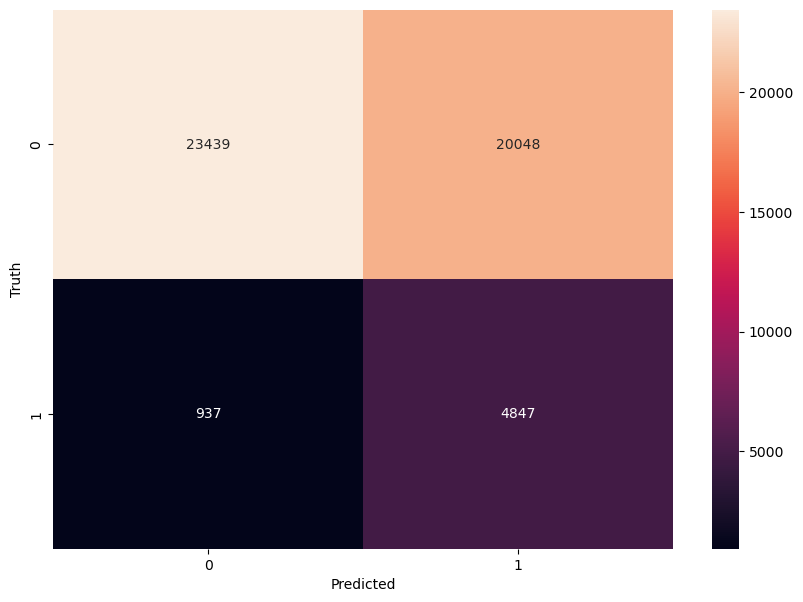

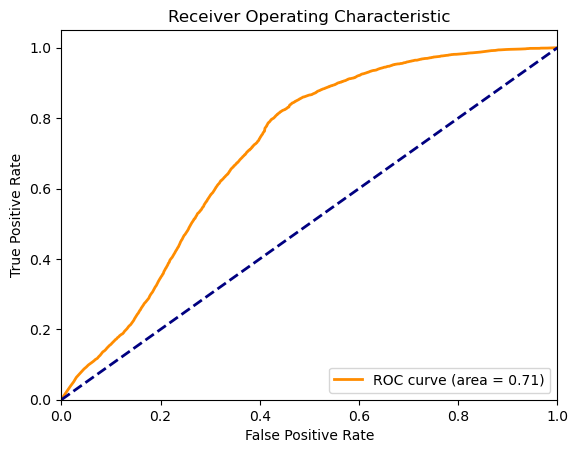

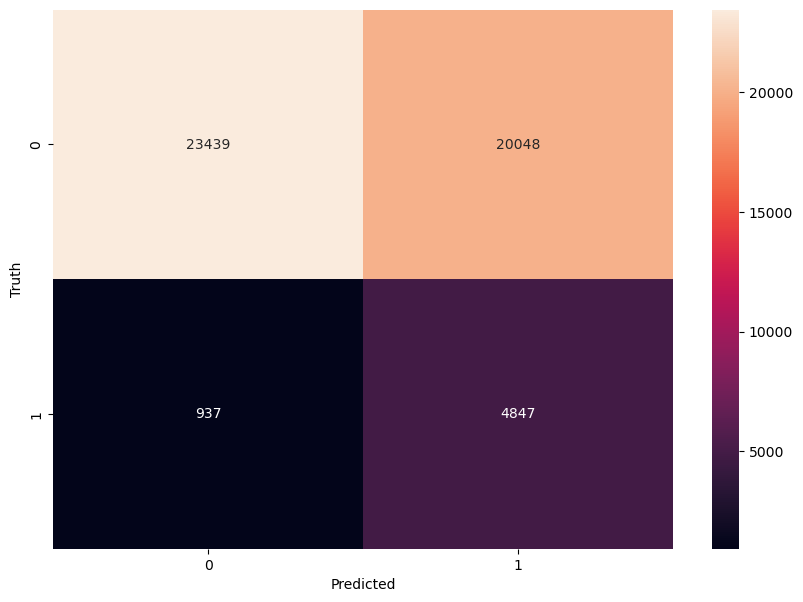

In [30]:

# Forward pass
log_softmax_train, first_l_x, feat = model(X_train_tensor)
# Forward pass
log_softmax_test, first_l_x, feat = model(X_test_tensor)


# Apply the model to X_train and X_test
X_train_transformed = log_softmax_train.detach().numpy()
X_test_transformed = log_softmax_test.detach().numpy()


# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(X_train_transformed, y_train)

# Predict the classes of the test set
y_pred = clf.predict(X_test_transformed)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# DL IB Model (Jathu)

## Without Noise

Epoch [0/500], Loss: 2.0947
Epoch [50/500], Loss: 0.7171
Epoch [100/500], Loss: 0.3977
Epoch [150/500], Loss: 0.2741
Epoch [200/500], Loss: 0.2308
Epoch [250/500], Loss: 0.1991
Epoch [300/500], Loss: 0.1794
Epoch [350/500], Loss: 0.1723
Epoch [400/500], Loss: 0.1649
Epoch [450/500], Loss: 0.1567


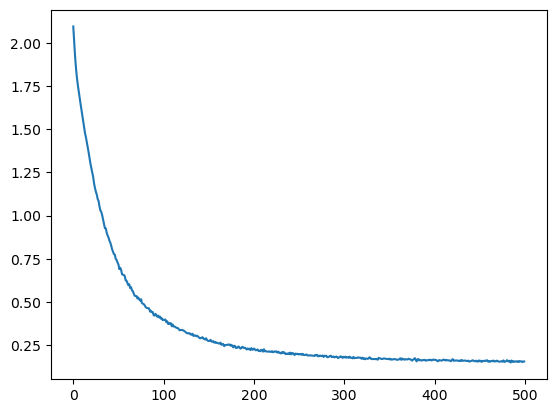

In [31]:
class ECGEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(ECGEncoder, self).__init__()
        self.norm = nn.BatchNorm1d(in_channels)
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        self.feature_IB_fc = nn.Linear(in_features=in_channels, out_features=hidden_channels, bias=False)


    def forward(self, x):
        x = self.norm(x)
        first_l_x = x
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        feat = x
        x = self.fc2(x)

        # Get importance mask
        p = self.feature_IB_fc(first_l_x)
        mask = self.get_importance_mask(p)
        neg_mask = 1 - mask

        # Calculate mean and std for each signal
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x_std = torch.std(x, dim=1, keepdim=True)

        # Add noise to the signal
#         print("mask.shape: ", mask.shape)
#         print("x.shape: ", x.shape)
#         print("neg_mask.shape: ", neg_mask.shape)
#         print("x_mean.shape: ", x_mean.shape)
        
        noisy_signal_mean = x_mean #mask * x + neg_mask * x_mean
        noisy_signal_std = x_std #neg_mask * x_std
        masked_signal = noisy_signal_mean + noisy_signal_std * torch.rand_like(x)
        


        # Calculate KL divergence loss
        epsilon = 1e-7
        kl_loss = 0.5 * ((noisy_signal_std**2) / ((x_std + epsilon)**2)).mean() + ((noisy_signal_mean - x_mean) / (x_std + epsilon)**2).mean()

        return F.log_softmax(x, dim=-1), first_l_x, feat, kl_loss
   
    
    def get_importance_mask(self, p):
        temperature = 1.0
        bias = 0.0 + 0.0001
#         print("p: ", p)
#         print("p.size: ", p.shape)
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)  # Change here

        #mask (apply gumbel sigmoid)
        mask = (torch.log(eps) - torch.log(1 - eps))
        mask = torch.sigmoid((p + mask) / temperature)
        return mask

# Create the model
model = ECGEncoder(
    in_channels=X_train.shape[1],  # Input feature dimension
    hidden_channels=32,  # Dimension of hidden layers
    out_channels=6, #num_classes['your_dataset'],  # Output dimension
    dropout=0.2,  # Dropout rate
)

def train(model, X_train, y_train, optimizer, args):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    #log_softmax, first_l_x, feat 
    log_softmax = model(X_train)
    
    #F = torch.nn.functional
    #nll_loss = Negative Log-Likelihood loss
    # Compute the loss
    loss = F.nll_loss(log_softmax[0], y_train.long())
    loss_list = []
    loss_list.append(loss.unsqueeze(0))
    loss_list = torch.cat(loss_list, dim=0)
    loss = torch.mean(loss_list)
   
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return {'final_loss': loss.item()}

# List to store losses for each epoch
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
args = Args()
# Train the model
N = 500
for epoch in range(N):
    loss_dict = train(model, X_train_tensor, y_train_tensor, optimizer, args)
    
    # Store the loss
    losses.append(loss_dict['final_loss'])
    
    # Print loss for every 10 epoch
    if epoch % (N//10) == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, N, loss_dict['final_loss']))
plt.plot(losses)

              precision    recall  f1-score   support

           0       0.98      0.49      0.66     43487
           1       0.19      0.91      0.32      5784

    accuracy                           0.54     49271
   macro avg       0.58      0.70      0.49     49271
weighted avg       0.88      0.54      0.62     49271



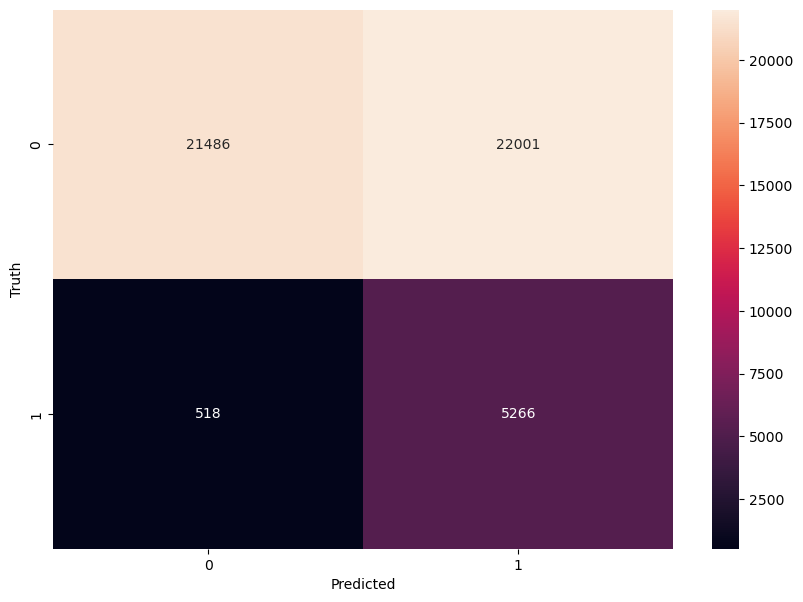

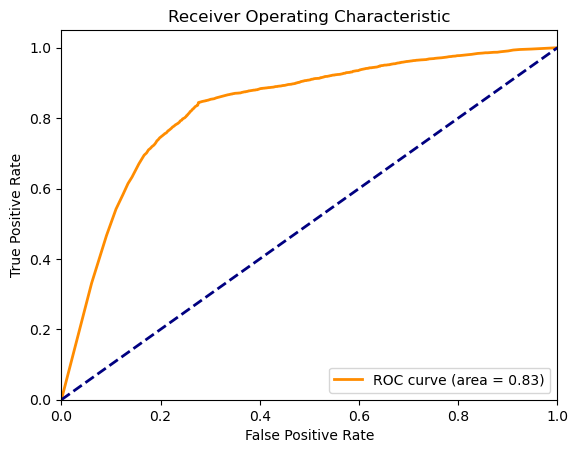

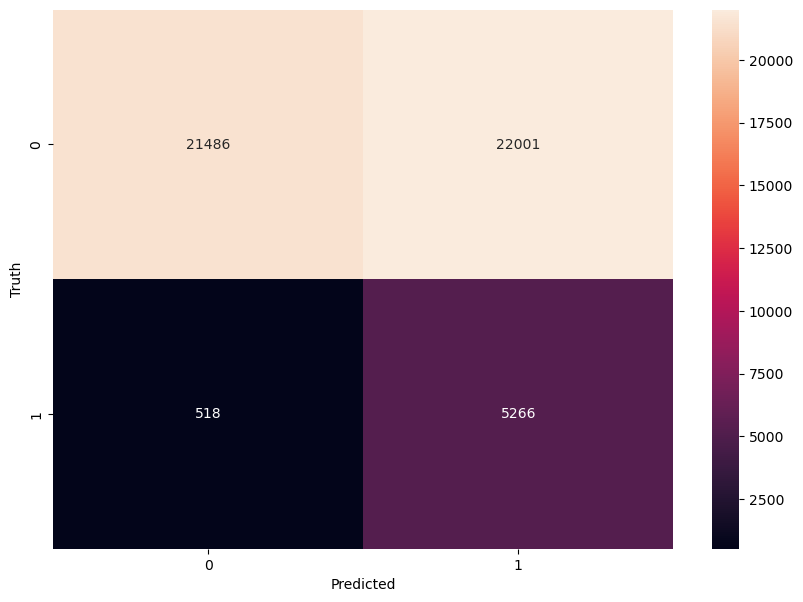

In [32]:

# Forward pass
# Transform the training data
log_softmax_train, first_l_x_train, feat_train, kl_loss_train = model(X_train_tensor)

# Transform the test data
log_softmax_test, first_l_x_test, feat_test, kl_loss_test = model(X_test_tensor)


# Apply the model to X_train and X_test
X_train_transformed = log_softmax_train.detach().numpy()
X_test_transformed = log_softmax_test.detach().numpy()


# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(X_train_transformed, y_train)

# Predict the classes of the test set
y_pred = clf.predict(X_test_transformed)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# ## With Noise 

Epoch [0/200], Loss: 1.9217
Epoch [20/200], Loss: 1.0082
Epoch [40/200], Loss: 0.6543
Epoch [60/200], Loss: 0.5312
Epoch [80/200], Loss: 0.4432
Epoch [100/200], Loss: 0.3795
Epoch [120/200], Loss: 0.3191
Epoch [140/200], Loss: 0.2814
Epoch [160/200], Loss: 0.2512
Epoch [180/200], Loss: 0.2291


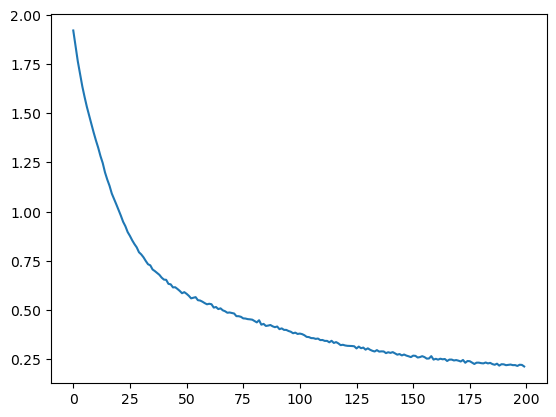

In [33]:
class ECGEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(ECGEncoder, self).__init__()
        self.norm = nn.BatchNorm1d(in_channels)
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        self.feature_IB_fc = nn.Linear(in_features=in_channels, out_features=hidden_channels, bias=False)


    def forward(self, x):
        x = self.norm(x)
        first_l_x = x
        x = F.relu(self.fc1(x))


        # Get importance mask
        p = self.feature_IB_fc(first_l_x)
        mask = self.get_importance_mask(p)
        neg_mask = 1 - mask

        # Calculate mean and std for each signal
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x_std = torch.std(x, dim=1, keepdim=True)

        # Add noise to the signal
#         print("mask.shape: ", mask.shape)
#         print("x.shape: ", x.shape)
#         print("neg_mask.shape: ", neg_mask.shape)
#         print("x_mean.shape: ", x_mean.shape)
#         print("neg_mask * x_mean: ", (neg_mask * x_mean).shape)
#         print("mask * x.shape: ", (mask * x).shape)
        
#         noisy_signal_mean = x_mean #mask * x + neg_mask * x_mean
#         noisy_signal_std = x_std #neg_mask * x_std
        noisy_signal_mean = mask * x + neg_mask * x_mean
        noisy_signal_std = neg_mask * x_std
        masked_signal = noisy_signal_mean + noisy_signal_std * torch.rand_like(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        feat = x
        x = self.fc2(x)

        # Calculate KL divergence loss
        epsilon = 1e-7
        kl_loss = 0.5 * ((noisy_signal_std**2) / ((x_std + epsilon)**2)).mean() + ((noisy_signal_mean - x_mean) / (x_std + epsilon)**2).mean()

        return F.log_softmax(x, dim=-1), first_l_x, feat, kl_loss
   
    
    def get_importance_mask(self, p):
        temperature = 1.0
        bias = 0.0 + 0.0001
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)  # Change here

        #mask (apply gumbel sigmoid)
        mask = (torch.log(eps) - torch.log(1 - eps))
        mask = torch.sigmoid((p + mask) / temperature)
        return mask

# Create the model
model = ECGEncoder(
    in_channels=X_train.shape[1],  # Input feature dimension
    hidden_channels=32,  # Dimension of hidden layers
    out_channels=6, #num_classes['your_dataset'],  # Output dimension
    dropout=0.2,  # Dropout rate
)

def train(model, X_train, y_train, optimizer, args):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    #log_softmax, first_l_x, feat 
    log_softmax = model(X_train)
    
    #F = torch.nn.functional
    #nll_loss = Negative Log-Likelihood loss
    # Compute the loss
    loss = F.nll_loss(log_softmax[0], y_train.long())
    loss_list = []
    loss_list.append(loss.unsqueeze(0))
    loss_list = torch.cat(loss_list, dim=0)
    loss = torch.mean(loss_list)
   
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return {'final_loss': loss.item()}

# List to store losses for each epoch
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
args = Args()
# Train the model
N = 200
for epoch in range(N):
    loss_dict = train(model, X_train_tensor, y_train_tensor, optimizer, args)
    
    # Store the loss
    losses.append(loss_dict['final_loss'])
    
    # Print loss for every 10 epoch
    if epoch % (N//10) == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, N, loss_dict['final_loss']))
plt.plot(losses)

              precision    recall  f1-score   support

           0       0.98      0.48      0.65     43487
           1       0.19      0.92      0.32      5784

    accuracy                           0.53     49271
   macro avg       0.58      0.70      0.48     49271
weighted avg       0.89      0.53      0.61     49271



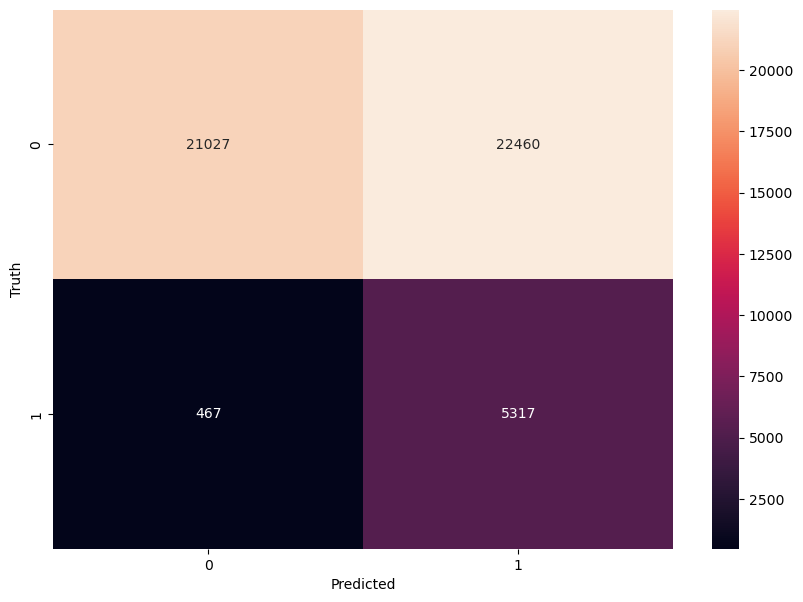

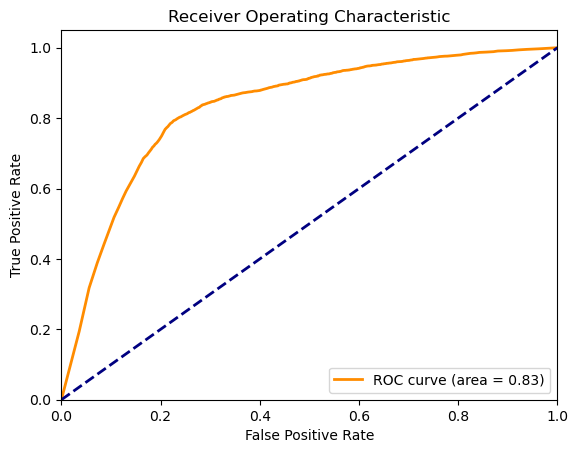

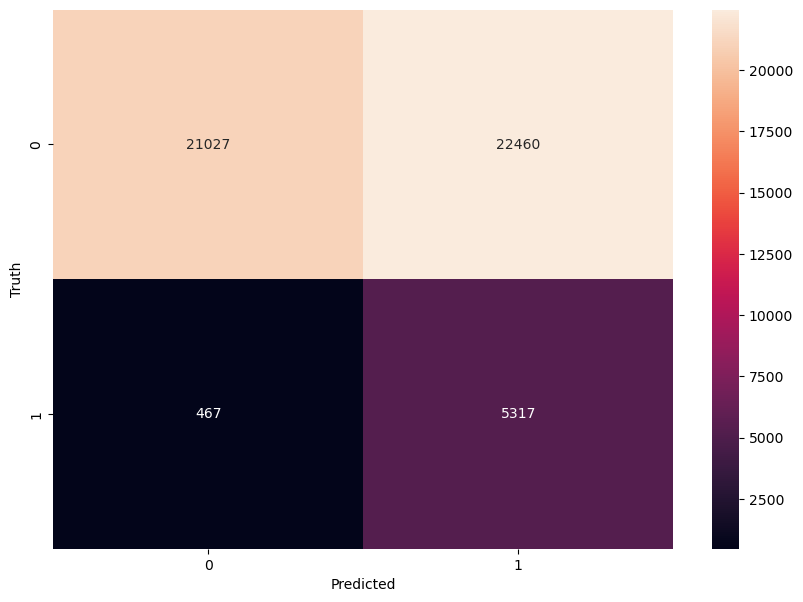

In [34]:

# Forward pass
# Transform the training data
log_softmax_train, first_l_x_train, feat_train, kl_loss_train = model(X_train_tensor)

# Transform the test data
log_softmax_test, first_l_x_test, feat_test, kl_loss_test = model(X_test_tensor)


# Apply the model to X_train and X_test
X_train_transformed = log_softmax_train.detach().numpy()
X_test_transformed = log_softmax_test.detach().numpy()


# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=100)

# Train the classifier
clf.fit(X_train_transformed, y_train)

# Predict the classes of the test set
y_pred = clf.predict(X_test_transformed)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Compute the probabilities of the test set
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()